In [22]:
import numpy as np
import torch 
import pandas as pd
from pickle import FALSE, TRUE
from scipy.stats import norm 
import itertools
from itertools import repeat 
import scipy.stats as sts 
from torch.distributions import Normal  
import time
import cProfile as profile
import pstats
import seaborn as sns
import importlib
from plotnine import *
import time

# for profiling
import cProfile, pstats, io
from pstats import SortKey

# helper functions from within the library
import helper
import init_params_tensor
import init_model_tensor
import main_sim_tensor
import compute_prob_tensor


In [71]:

importlib.reload(helper)
importlib.reload(compute_prob_tensor)
importlib.reload(init_params_tensor)
importlib.reload(init_model_tensor)
importlib.reload(main_sim_tensor)

params = init_params_tensor.granch_params(
      grid_mu = torch.linspace(start = -1, end = 1, steps = 20),
      grid_sigma = torch.linspace(start = 0.001, end = 1.8, steps = 20), 
      grid_y = torch.linspace(start = -1, end = 1, steps = 20), 
      grid_epsilon =  torch.linspace(start = 0.001, end = 1.8, steps = 20), 
      hypothetical_obs_grid_n = 10, 
      mu_prior = 0.001,
      V_prior = 0.001, 
      alpha_prior = 1, 
      beta_prior = 1,
      epsilon  = 0.000001, 
      mu_epsilon = torch.tensor([0.001]), 
      sd_epsilon = torch.tensor([4]), 
      world_EIGs = 0.0001,
      max_observation = 500)

# add the various different cached bits
params.add_meshed_grid()
params.add_lp_mu_sigma()
params.add_y_given_mu_sigma()
params.add_lp_epsilon()
params.add_priors()

tensor_stimuli = init_model_tensor.granch_stimuli(1, 'BBBBBB')
tensor_model = init_model_tensor.granch_model(500, tensor_stimuli)


res = main_sim_tensor.granch_main_simulation(params, tensor_model, tensor_stimuli)




In [19]:
from memory_profiler import profile

@profile
def run_model():
    res = main_sim_tensor.granch_main_simulation(params, tensor_model, tensor_stimuli)
    


In [38]:


# initialize parameters
params = init_params_tensor.granch_params(
      grid_mu = torch.linspace(start = -1, end = 1, steps = 8),
      grid_sigma = torch.linspace(start = 0.001, end = 1.8, steps = 10), 
      grid_y = torch.linspace(start = -1, end = 1, steps = 3), 
      grid_epsilon =  torch.linspace(start = 0.001, end = 1.8, steps = 3), 
      hypothetical_obs_grid_n = 5, 
      mu_prior = 0.001,
      V_prior = 0.001, 
      alpha_prior = 1, 
      beta_prior = 1,
      epsilon  = 0.000001, 
      mu_epsilon = torch.tensor([0.001]), 
      sd_epsilon = torch.tensor([4]), 
      world_EIGs = 0.0001,
      max_observation = 500)

# add the various different cached bits
params.add_meshed_grid()



def score_mu_sigma(input_x, input_sigma, mu, nu, alpha, beta, log, device):
    '''
    The probability density function of the normal-inverse-gamma distribution at
    input_x (mean) and input_sigma (variance).
    '''
    
    res = (
        sts.norm.pdf(input_x.cpu().numpy(), loc=mu, scale=np.sqrt(input_sigma**2 / nu)) *
        sts.invgamma.pdf(input_sigma.cpu().numpy()**2, a=alpha, scale=beta))
    
    #print("normal")
    #print(np.log(sts.norm.pdf(input_x.cpu().numpy(), loc=mu, scale=np.sqrt(input_sigma**2 / nu))))
    #print("ig")
    #print(np.log(sts.invgamma.pdf(input_sigma.cpu().numpy()**2, a=alpha, scale=beta)))

    return torch.from_numpy(np.log(res)).to(device) if log else torch.from_numpy(res).to(device)



lp_mu_sigma = score_mu_sigma(
            input_x = params.meshed_grid_mu,                                          
            input_sigma = params.meshed_grid_sigma, 
            mu  = params.mu_prior, 
            nu = params.V_prior, 
            alpha = params.alpha_prior,
            beta = params.beta_prior, 
            log = True, 
            device = params.device)

print(lp_mu_sigma)

tensor([[[[    -inf,     -inf,     -inf],
          [    -inf,     -inf,     -inf],
          [    -inf,     -inf,     -inf]],

         [[-21.1395, -21.1395, -21.1395],
          [-21.1395, -21.1395, -21.1395],
          [-21.1395, -21.1395, -21.1395]],

         [[ -6.0300,  -6.0300,  -6.0300],
          [ -6.0300,  -6.0300,  -6.0300],
          [ -6.0300,  -6.0300,  -6.0300]],

         [[ -4.5972,  -4.5972,  -4.5972],
          [ -4.5972,  -4.5972,  -4.5972],
          [ -4.5972,  -4.5972,  -4.5972]],

         [[ -4.8217,  -4.8217,  -4.8217],
          [ -4.8217,  -4.8217,  -4.8217],
          [ -4.8217,  -4.8217,  -4.8217]],

         [[ -5.3747,  -5.3747,  -5.3747],
          [ -5.3747,  -5.3747,  -5.3747],
          [ -5.3747,  -5.3747,  -5.3747]],

         [[ -5.9802,  -5.9802,  -5.9802],
          [ -5.9802,  -5.9802,  -5.9802],
          [ -5.9802,  -5.9802,  -5.9802]],

         [[ -6.5663,  -6.5663,  -6.5663],
          [ -6.5663,  -6.5663,  -6.5663],
          [ -6.5663,

/var/folders/1y/l17j6svd6jq5_j5s7s92yh8m0000gn/T/ipykernel_88696/1614138050.py:38: RuntimeWarning: divide by zero encountered in log


In [39]:


def new_score_mu_sigma(input_x, input_sigma, mu, nu, alpha, beta):
    '''
    The probability density function of the normal-inverse-gamma distribution at
    input_x (mean) and input_sigma (variance).
    '''

    res = (
        Normal(mu, torch.sqrt(input_sigma ** 2 / nu)).log_prob(input_x)  + 
        InverseGamma(alpha, beta).log_prob(input_sigma ** 2)
    )
    
    return res



lp_mu_sigma = score_mu_sigma(
            input_x = params.meshed_grid_mu,                                          
            input_sigma = params.meshed_grid_sigma, 
            mu  = params.mu_prior, 
            nu = params.V_prior, 
            alpha = params.alpha_prior,
            beta = params.beta_prior, 
            log = True, 
            device = params.device)


new_lp_mu_sigma = new_score_mu_sigma(input_x = params.meshed_grid_mu,                                          
            input_sigma = params.meshed_grid_sigma, 
            mu  = params.mu_prior, 
            nu = params.V_prior, 
            alpha = params.alpha_prior,
            beta = params.beta_prior)

print(lp_mu_sigma)
print(new_lp_mu_sigma)

tensor([[[[    -inf,     -inf,     -inf],
          [    -inf,     -inf,     -inf],
          [    -inf,     -inf,     -inf]],

         [[-21.1395, -21.1395, -21.1395],
          [-21.1395, -21.1395, -21.1395],
          [-21.1395, -21.1395, -21.1395]],

         [[ -6.0300,  -6.0300,  -6.0300],
          [ -6.0300,  -6.0300,  -6.0300],
          [ -6.0300,  -6.0300,  -6.0300]],

         [[ -4.5972,  -4.5972,  -4.5972],
          [ -4.5972,  -4.5972,  -4.5972],
          [ -4.5972,  -4.5972,  -4.5972]],

         [[ -4.8217,  -4.8217,  -4.8217],
          [ -4.8217,  -4.8217,  -4.8217],
          [ -4.8217,  -4.8217,  -4.8217]],

         [[ -5.3747,  -5.3747,  -5.3747],
          [ -5.3747,  -5.3747,  -5.3747],
          [ -5.3747,  -5.3747,  -5.3747]],

         [[ -5.9802,  -5.9802,  -5.9802],
          [ -5.9802,  -5.9802,  -5.9802],
          [ -5.9802,  -5.9802,  -5.9802]],

         [[ -6.5663,  -6.5663,  -6.5663],
          [ -6.5663,  -6.5663,  -6.5663],
          [ -6.5663,

/var/folders/1y/l17j6svd6jq5_j5s7s92yh8m0000gn/T/ipykernel_88696/1614138050.py:38: RuntimeWarning: divide by zero encountered in log


# Consolidated comparison

In [2]:
importlib.reload(helper)
importlib.reload(compute_prob)
importlib.reload(compute_prob_tensor)
importlib.reload(init_params_tensor)
importlib.reload(init_params)
importlib.reload(init_model_tensor)
importlib.reload(init_model)
importlib.reload(main_sim_tensor)
importlib.reload(ps)

<module 'params_search' from '/Users/caoanjie/Desktop/projects/model/model/GRANCH_python/params_search.py'>

## original 

In [3]:
o_param = init_params.granch_params(
      grid_mu_theta = torch.linspace(start = -1, end = 1, steps = 5),
      grid_sig_sq = torch.linspace(start = 0.001, end = 1.8, steps = 3), 
      grid_y = torch.linspace(start = -1, end = 1, steps = 3), 
      grid_epsilon =  torch.linspace(start = 0.001, end = 1.8, steps = 3), 
      hypothetical_obs_grid_n = 5, 
      mu_prior = 0.001,
      V_prior = 0.001, 
      alpha_prior = 1, 
      beta_prior = 1,
      epsilon  = 0.000001, 
      mu_epsilon = torch.tensor([0.001]), 
      sd_epsilon = torch.tensor([4]), 
      world_EIGs = 0.0001,
      max_observation = 500)


o_param.add_meshed_grid()
o_param.add_lp_mu_sig_sq()
o_param.add_y_given_mu_sig_sq()
o_param.add_lp_epsilon()
o_param.add_priors()

stimuli = init_model.granch_stimuli(1, 'BBBBBB')
model = init_model.granch_model(500, stimuli)


o_res = main_sim.granch_main_simulation(o_param, model, stimuli)
#print(stimuli)
#print(o_res.behavior)


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torch/functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:2895.)
/Users/caoanjie/Desktop/projects/model/model/GRANCH_python/compute_prob.py:149: RuntimeWarning: divide by zero encountered in log


## tensor

In [4]:
# initialize parameters
params = init_params_tensor.granch_params(
      grid_mu = torch.linspace(start = -1, end = 1, steps = 5),
      grid_sigma = torch.linspace(start = 0.001, end = 1.8, steps = 3), 
      grid_y = torch.linspace(start = -1, end = 1, steps = 3), 
      grid_epsilon =  torch.linspace(start = 0.001, end = 1.8, steps = 3), 
      hypothetical_obs_grid_n = 5, 
      mu_prior = 0.001,
      V_prior = 0.001, 
      alpha_prior = 1, 
      beta_prior = 1,
      epsilon  = 0.000001, 
      mu_epsilon = torch.tensor([0.001]), 
      sd_epsilon = torch.tensor([4]), 
      world_EIGs = 0.0001,
      max_observation = 500)

# add the various different cached bits
params.add_meshed_grid()
params.add_lp_mu_sigma()
params.add_y_given_mu_sigma()
params.add_lp_epsilon()
params.add_priors()

# initialize the model
tensor_stimuli = init_model_tensor.granch_stimuli(1, 'BBBBBB')
tensor_model = init_model_tensor.granch_model(500, tensor_stimuli)


res = main_sim_tensor.granch_main_simulation(params, tensor_model, stimuli)
print(res.behavior)


    stimulus_id       EIG Look_away
0             0  0.035864     False
1             0  0.034931     False
2             0  0.026614     False
3             0  0.016764     False
4             0  0.009322     False
..          ...       ...       ...
495         NaN       NaN       NaN
496         NaN       NaN       NaN
497         NaN       NaN       NaN
498         NaN       NaN       NaN
499         NaN       NaN       NaN

[500 rows x 3 columns]


/Users/caoanjie/Desktop/projects/model/model/GRANCH_python/compute_prob_tensor.py:151: RuntimeWarning: divide by zero encountered in log


# Visualizing the comparison 

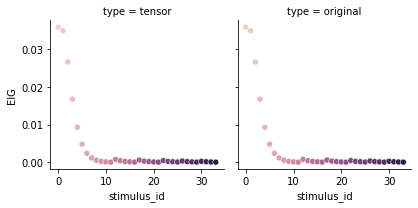

In [5]:
def compare_eig(res, o_res):
    behavior = res.behavior 
    behavior["type"] = "tensor"
    o_behavior = o_res.behavior
    o_behavior["type"] = "original"

    c_df = pd.concat([behavior, o_behavior])
    c_df = c_df.dropna(subset = ["stimulus_id"])

    c_df['stimulus_id'] = c_df.index
    

    p = sns.FacetGrid(c_df, col="type")
    p.map_dataframe(sns.scatterplot, x="stimulus_id", y = "EIG", hue = "stimulus_id")
    return (p)
    #return (c_df)

    #



pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

compare_eig(res, o_res)




# Timing 

In [10]:
def compare_timing(step_n, hypo_observation_n):

    # time the original one
    o_start_time = time.perf_counter()

    o_param = init_params.granch_params(
      grid_mu_theta = torch.linspace(start = -1, end = 1, steps = step_n),
      grid_sig_sq = torch.linspace(start = 0.001, end = 1.8, steps = step_n), 
      grid_y = torch.linspace(start = -1, end = 1, steps = step_n), 
      grid_epsilon =  torch.linspace(start = 0.001, end = 1.8, steps = step_n), 
      hypothetical_obs_grid_n = hypo_observation_n, 
      mu_prior = 0.001,
      V_prior = 0.001, 
      alpha_prior = 1, 
      beta_prior = 1,
      epsilon  = 0.000001, 
      mu_epsilon = torch.tensor([0.001]), 
      sd_epsilon = torch.tensor([4]), 
      world_EIGs = 0.0001,
      max_observation = 500)


    o_param.add_meshed_grid()
    o_param.add_lp_mu_sig_sq()
    o_param.add_y_given_mu_sig_sq()
    o_param.add_lp_epsilon()
    o_param.add_priors()

    stimuli = init_model.granch_stimuli(1, 'BBBBBB')
    model = init_model.granch_model(500, stimuli)
    #o_res = main_sim.granch_main_simulation(o_param, model, stimuli)

    o_end_time = time.perf_counter()
    o_elapsed_time = o_end_time - o_start_time

    # time the tensor one

    start_time = time.perf_counter()
    params = init_params_tensor.granch_params(
      grid_mu = torch.linspace(start = -1, end = 1, steps = step_n),
      grid_sigma = torch.linspace(start = 0.001, end = 1.8, steps = step_n), 
      grid_y = torch.linspace(start = -1, end = 1, steps = step_n), 
      grid_epsilon =  torch.linspace(start = 0.001, end = 1.8, steps = step_n), 
      hypothetical_obs_grid_n = hypo_observation_n, 
      mu_prior = 0.001,
      V_prior = 0.001, 
      alpha_prior = 1, 
      beta_prior = 1,
      epsilon  = 0.000001, 
      mu_epsilon = torch.tensor([0.001]), 
      sd_epsilon = torch.tensor([4]), 
      world_EIGs = 0.0001,
      max_observation = 500)

  # add the various different cached bits
    params.add_meshed_grid()
    params.add_lp_mu_sigma()
    params.add_y_given_mu_sigma()
    params.add_lp_epsilon()
    params.add_priors()

    # initialize the model
    tensor_stimuli = init_model_tensor.granch_stimuli(1, 'BBBBBB')
    tensor_model = init_model_tensor.granch_model(500, tensor_stimuli)
    
    res = main_sim_tensor.granch_main_simulation(params, tensor_model, stimuli)
    end_time = time.perf_counter()

    elapsed_time = end_time - start_time

    compare_eig(res, o_res)

    timed_res = {
        "type": ["original", "tensor"], 
        't': [o_elapsed_time, elapsed_time], 
        "grid_step": [step_n, step_n], 
        "hypo_n": [hypo_observation_n, hypo_observation_n]
    }

    return (timed_res)








/Users/caoanjie/Desktop/projects/model/model/GRANCH_python/compute_prob.py:149: RuntimeWarning: divide by zero encountered in log
/Users/caoanjie/Desktop/projects/model/model/GRANCH_python/compute_prob_tensor.py:151: RuntimeWarning: divide by zero encountered in log


,type,t,grid_step,hypo_n
0,original,0.036939,10,10
1,tensor,0.696120,10,10


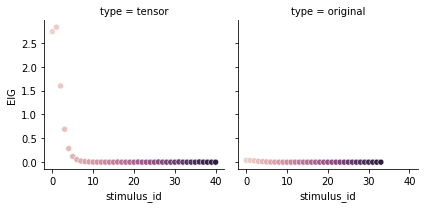

In [13]:
pd.DataFrame(compare_timing(10, 10))

# Test stability 

In [14]:
def test_step_stability(grid_step, hypo_obs_step): 
  # initialize parameters
  start_time = time.perf_counter()
  params = init_params_tensor.granch_params(
      grid_mu = torch.linspace(start = -1, end = 1, steps = grid_step),
      grid_sigma = torch.linspace(start = 0.001, end = 1.8, steps = grid_step), 
      grid_y = torch.linspace(start = -1, end = 1, steps = grid_step), 
      grid_epsilon =  torch.linspace(start = 0.001, end = 1.8, steps = grid_step), 
      hypothetical_obs_grid_n = hypo_obs_step, 
      mu_prior = 0.001,
      V_prior = 0.001, 
      alpha_prior = 1, 
      beta_prior = 1,
      epsilon  = 0.000001, 
      mu_epsilon = torch.tensor([0.001]), 
      sd_epsilon = torch.tensor([4]), 
      world_EIGs = 0.0001,
      max_observation = 500)
  # add the various different cached bits
  params.add_meshed_grid()
  params.add_lp_mu_sigma()
  params.add_y_given_mu_sigma()
  params.add_lp_epsilon()
  params.add_priors()
  tensor_stimuli = init_model_tensor.granch_stimuli(1, 'BBBBBB')
  tensor_model = init_model_tensor.granch_model(500, tensor_stimuli)
  res = main_sim_tensor.granch_main_simulation(params, tensor_model, tensor_stimuli)
  end_time = time.perf_counter()
  t = end_time - start_time
  b = res.behavior
  b["grid_step"] = grid_step 
  b["hypo_obs_step"] = hypo_obs_step
  b["time"] = t
  return b 


  


In [17]:

grid_step_n = pd.DataFrame({"grid_step": list(range(2, 11))})
hypo_step_n = pd.DataFrame({"hypo_obs_step": list(range(2, 11))})
grid_step_n["key"] = 0
hypo_step_n["key"] = 0

step_df = grid_step_n.merge(hypo_step_n, on = "key", how = "outer")
#print(step_df)
res_df = pd.DataFrame()
for i in range(0, len(step_df)): 
  print(i)
  temp_res = test_step_stability(step_df["grid_step"][i], step_df["hypo_obs_step"][i])
  temp_res.index.name = 't'
  temp_res.reset_index(inplace = True)
  res_df = pd.concat([res_df, temp_res])

0
1
2
3
4
5
6
7


/Users/caoanjie/Desktop/projects/model/model/GRANCH_python/compute_prob_tensor.py:151: RuntimeWarning: divide by zero encountered in log
/Users/caoanjie/Desktop/projects/model/model/GRANCH_python/compute_prob_tensor.py:151: RuntimeWarning: divide by zero encountered in log
/Users/caoanjie/Desktop/projects/model/model/GRANCH_python/compute_prob_tensor.py:151: RuntimeWarning: divide by zero encountered in log
/Users/caoanjie/Desktop/projects/model/model/GRANCH_python/compute_prob_tensor.py:151: RuntimeWarning: divide by zero encountered in log
/Users/caoanjie/Desktop/projects/model/model/GRANCH_python/compute_prob_tensor.py:151: RuntimeWarning: divide by zero encountered in log
/Users/caoanjie/Desktop/projects/model/model/GRANCH_python/compute_prob_tensor.py:151: RuntimeWarning: divide by zero encountered in log
/Users/caoanjie/Desktop/projects/model/model/GRANCH_python/compute_prob_tensor.py:151: RuntimeWarning: divide by zero encountered in log
/Users/caoanjie/Desktop/projects/model/mo

8
9
10


/Users/caoanjie/Desktop/projects/model/model/GRANCH_python/compute_prob_tensor.py:151: RuntimeWarning: divide by zero encountered in log
/Users/caoanjie/Desktop/projects/model/model/GRANCH_python/compute_prob_tensor.py:151: RuntimeWarning: divide by zero encountered in log
/Users/caoanjie/Desktop/projects/model/model/GRANCH_python/compute_prob_tensor.py:151: RuntimeWarning: divide by zero encountered in log


11
12
13


/Users/caoanjie/Desktop/projects/model/model/GRANCH_python/compute_prob_tensor.py:151: RuntimeWarning: divide by zero encountered in log
/Users/caoanjie/Desktop/projects/model/model/GRANCH_python/compute_prob_tensor.py:151: RuntimeWarning: divide by zero encountered in log
/Users/caoanjie/Desktop/projects/model/model/GRANCH_python/compute_prob_tensor.py:151: RuntimeWarning: divide by zero encountered in log


14
15


/Users/caoanjie/Desktop/projects/model/model/GRANCH_python/compute_prob_tensor.py:151: RuntimeWarning: divide by zero encountered in log
/Users/caoanjie/Desktop/projects/model/model/GRANCH_python/compute_prob_tensor.py:151: RuntimeWarning: divide by zero encountered in log


16
17


/Users/caoanjie/Desktop/projects/model/model/GRANCH_python/compute_prob_tensor.py:151: RuntimeWarning: divide by zero encountered in log
/Users/caoanjie/Desktop/projects/model/model/GRANCH_python/compute_prob_tensor.py:151: RuntimeWarning: divide by zero encountered in log


18
19


/Users/caoanjie/Desktop/projects/model/model/GRANCH_python/compute_prob_tensor.py:151: RuntimeWarning: divide by zero encountered in log
/Users/caoanjie/Desktop/projects/model/model/GRANCH_python/compute_prob_tensor.py:151: RuntimeWarning: divide by zero encountered in log


20


/Users/caoanjie/Desktop/projects/model/model/GRANCH_python/compute_prob_tensor.py:151: RuntimeWarning: divide by zero encountered in log


21


/Users/caoanjie/Desktop/projects/model/model/GRANCH_python/compute_prob_tensor.py:151: RuntimeWarning: divide by zero encountered in log


22


/Users/caoanjie/Desktop/projects/model/model/GRANCH_python/compute_prob_tensor.py:151: RuntimeWarning: divide by zero encountered in log


23


/Users/caoanjie/Desktop/projects/model/model/GRANCH_python/compute_prob_tensor.py:151: RuntimeWarning: divide by zero encountered in log


24


/Users/caoanjie/Desktop/projects/model/model/GRANCH_python/compute_prob_tensor.py:151: RuntimeWarning: divide by zero encountered in log


25


/Users/caoanjie/Desktop/projects/model/model/GRANCH_python/compute_prob_tensor.py:151: RuntimeWarning: divide by zero encountered in log


26


/Users/caoanjie/Desktop/projects/model/model/GRANCH_python/compute_prob_tensor.py:151: RuntimeWarning: divide by zero encountered in log


27
28


/Users/caoanjie/Desktop/projects/model/model/GRANCH_python/compute_prob_tensor.py:151: RuntimeWarning: divide by zero encountered in log
/Users/caoanjie/Desktop/projects/model/model/GRANCH_python/compute_prob_tensor.py:151: RuntimeWarning: divide by zero encountered in log


29
30


/Users/caoanjie/Desktop/projects/model/model/GRANCH_python/compute_prob_tensor.py:151: RuntimeWarning: divide by zero encountered in log
/Users/caoanjie/Desktop/projects/model/model/GRANCH_python/compute_prob_tensor.py:151: RuntimeWarning: divide by zero encountered in log


31
32


/Users/caoanjie/Desktop/projects/model/model/GRANCH_python/compute_prob_tensor.py:151: RuntimeWarning: divide by zero encountered in log
/Users/caoanjie/Desktop/projects/model/model/GRANCH_python/compute_prob_tensor.py:151: RuntimeWarning: divide by zero encountered in log


33
34


/Users/caoanjie/Desktop/projects/model/model/GRANCH_python/compute_prob_tensor.py:151: RuntimeWarning: divide by zero encountered in log
/Users/caoanjie/Desktop/projects/model/model/GRANCH_python/compute_prob_tensor.py:151: RuntimeWarning: divide by zero encountered in log


35


/Users/caoanjie/Desktop/projects/model/model/GRANCH_python/compute_prob_tensor.py:151: RuntimeWarning: divide by zero encountered in log


36
37


/Users/caoanjie/Desktop/projects/model/model/GRANCH_python/compute_prob_tensor.py:151: RuntimeWarning: divide by zero encountered in log
/Users/caoanjie/Desktop/projects/model/model/GRANCH_python/compute_prob_tensor.py:151: RuntimeWarning: divide by zero encountered in log


38


/Users/caoanjie/Desktop/projects/model/model/GRANCH_python/compute_prob_tensor.py:151: RuntimeWarning: divide by zero encountered in log


39


/Users/caoanjie/Desktop/projects/model/model/GRANCH_python/compute_prob_tensor.py:151: RuntimeWarning: divide by zero encountered in log


40


/Users/caoanjie/Desktop/projects/model/model/GRANCH_python/compute_prob_tensor.py:151: RuntimeWarning: divide by zero encountered in log


41


/Users/caoanjie/Desktop/projects/model/model/GRANCH_python/compute_prob_tensor.py:151: RuntimeWarning: divide by zero encountered in log


42


/Users/caoanjie/Desktop/projects/model/model/GRANCH_python/compute_prob_tensor.py:151: RuntimeWarning: divide by zero encountered in log


43


/Users/caoanjie/Desktop/projects/model/model/GRANCH_python/compute_prob_tensor.py:151: RuntimeWarning: divide by zero encountered in log


44


/Users/caoanjie/Desktop/projects/model/model/GRANCH_python/compute_prob_tensor.py:151: RuntimeWarning: divide by zero encountered in log


45
46


/Users/caoanjie/Desktop/projects/model/model/GRANCH_python/compute_prob_tensor.py:151: RuntimeWarning: divide by zero encountered in log
/Users/caoanjie/Desktop/projects/model/model/GRANCH_python/compute_prob_tensor.py:151: RuntimeWarning: divide by zero encountered in log


47


/Users/caoanjie/Desktop/projects/model/model/GRANCH_python/compute_prob_tensor.py:151: RuntimeWarning: divide by zero encountered in log


48


/Users/caoanjie/Desktop/projects/model/model/GRANCH_python/compute_prob_tensor.py:151: RuntimeWarning: divide by zero encountered in log


49


/Users/caoanjie/Desktop/projects/model/model/GRANCH_python/compute_prob_tensor.py:151: RuntimeWarning: divide by zero encountered in log


50


/Users/caoanjie/Desktop/projects/model/model/GRANCH_python/compute_prob_tensor.py:151: RuntimeWarning: divide by zero encountered in log


51


/Users/caoanjie/Desktop/projects/model/model/GRANCH_python/compute_prob_tensor.py:151: RuntimeWarning: divide by zero encountered in log


52


/Users/caoanjie/Desktop/projects/model/model/GRANCH_python/compute_prob_tensor.py:151: RuntimeWarning: divide by zero encountered in log


53


/Users/caoanjie/Desktop/projects/model/model/GRANCH_python/compute_prob_tensor.py:151: RuntimeWarning: divide by zero encountered in log


54
55


/Users/caoanjie/Desktop/projects/model/model/GRANCH_python/compute_prob_tensor.py:151: RuntimeWarning: divide by zero encountered in log
/Users/caoanjie/Desktop/projects/model/model/GRANCH_python/compute_prob_tensor.py:151: RuntimeWarning: divide by zero encountered in log


56


/Users/caoanjie/Desktop/projects/model/model/GRANCH_python/compute_prob_tensor.py:151: RuntimeWarning: divide by zero encountered in log


57


/Users/caoanjie/Desktop/projects/model/model/GRANCH_python/compute_prob_tensor.py:151: RuntimeWarning: divide by zero encountered in log


58


/Users/caoanjie/Desktop/projects/model/model/GRANCH_python/compute_prob_tensor.py:151: RuntimeWarning: divide by zero encountered in log


59


/Users/caoanjie/Desktop/projects/model/model/GRANCH_python/compute_prob_tensor.py:151: RuntimeWarning: divide by zero encountered in log


60


/Users/caoanjie/Desktop/projects/model/model/GRANCH_python/compute_prob_tensor.py:151: RuntimeWarning: divide by zero encountered in log


61


/Users/caoanjie/Desktop/projects/model/model/GRANCH_python/compute_prob_tensor.py:151: RuntimeWarning: divide by zero encountered in log


62


/Users/caoanjie/Desktop/projects/model/model/GRANCH_python/compute_prob_tensor.py:151: RuntimeWarning: divide by zero encountered in log


63
64


/Users/caoanjie/Desktop/projects/model/model/GRANCH_python/compute_prob_tensor.py:151: RuntimeWarning: divide by zero encountered in log
/Users/caoanjie/Desktop/projects/model/model/GRANCH_python/compute_prob_tensor.py:151: RuntimeWarning: divide by zero encountered in log


65


/Users/caoanjie/Desktop/projects/model/model/GRANCH_python/compute_prob_tensor.py:151: RuntimeWarning: divide by zero encountered in log


66


/Users/caoanjie/Desktop/projects/model/model/GRANCH_python/compute_prob_tensor.py:151: RuntimeWarning: divide by zero encountered in log


67


/Users/caoanjie/Desktop/projects/model/model/GRANCH_python/compute_prob_tensor.py:151: RuntimeWarning: divide by zero encountered in log


68


/Users/caoanjie/Desktop/projects/model/model/GRANCH_python/compute_prob_tensor.py:151: RuntimeWarning: divide by zero encountered in log


69


/Users/caoanjie/Desktop/projects/model/model/GRANCH_python/compute_prob_tensor.py:151: RuntimeWarning: divide by zero encountered in log


70


/Users/caoanjie/Desktop/projects/model/model/GRANCH_python/compute_prob_tensor.py:151: RuntimeWarning: divide by zero encountered in log


71


/Users/caoanjie/Desktop/projects/model/model/GRANCH_python/compute_prob_tensor.py:151: RuntimeWarning: divide by zero encountered in log


72
73


/Users/caoanjie/Desktop/projects/model/model/GRANCH_python/compute_prob_tensor.py:151: RuntimeWarning: divide by zero encountered in log
/Users/caoanjie/Desktop/projects/model/model/GRANCH_python/compute_prob_tensor.py:151: RuntimeWarning: divide by zero encountered in log


74


/Users/caoanjie/Desktop/projects/model/model/GRANCH_python/compute_prob_tensor.py:151: RuntimeWarning: divide by zero encountered in log


75


/Users/caoanjie/Desktop/projects/model/model/GRANCH_python/compute_prob_tensor.py:151: RuntimeWarning: divide by zero encountered in log


76


/Users/caoanjie/Desktop/projects/model/model/GRANCH_python/compute_prob_tensor.py:151: RuntimeWarning: divide by zero encountered in log


77


/Users/caoanjie/Desktop/projects/model/model/GRANCH_python/compute_prob_tensor.py:151: RuntimeWarning: divide by zero encountered in log


78


/Users/caoanjie/Desktop/projects/model/model/GRANCH_python/compute_prob_tensor.py:151: RuntimeWarning: divide by zero encountered in log


79


/Users/caoanjie/Desktop/projects/model/model/GRANCH_python/compute_prob_tensor.py:151: RuntimeWarning: divide by zero encountered in log


80


/Users/caoanjie/Desktop/projects/model/model/GRANCH_python/compute_prob_tensor.py:151: RuntimeWarning: divide by zero encountered in log


# Profiling of improved logsumexp

In [ ]:
pr = cProfile.Profile()
pr.enable()
res = main_sim.granch_main_simulation(p, m, s)
pr.disable()
s = io.StringIO()
sortby = SortKey.CUMULATIVE
ps = pstats.Stats(pr, stream=s).sort_stats(sortby)
ps.print_stats()
print(s.getvalue())

         157214 function calls (154501 primitive calls) in 9.998 seconds

   Ordered by: cumulative time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        2    0.000    0.000    9.998    4.999 /Users/mcfrank/Projects/pokebaby/looking_time_models/.venv/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3406(run_code)
        2    0.000    0.000    9.998    4.999 {built-in method builtins.exec}
        1    0.000    0.000    9.998    9.998 /var/folders/c1/4_sgh_lx3h5c7c8r9w3xs6f00000gq/T/ipykernel_57633/2873141792.py:3(<module>)
        1    0.009    0.009    9.998    9.998 /Users/mcfrank/Projects/pokebaby/looking_time_models/GRANCH_python/main_sim.py:39(granch_main_simulation)
      252    0.050    0.000    8.420    0.033 /Users/mcfrank/Projects/pokebaby/looking_time_models/GRANCH_python/helper.py:49(group_by_logsumexp_improved)
  504/252    0.002    0.000    6.874    0.027 /Users/mcfrank/Projects/pokebaby/looking_time_models/.venv/lib/python3.9/

<AxesSubplot:xlabel='index_column', ylabel='EIG'>

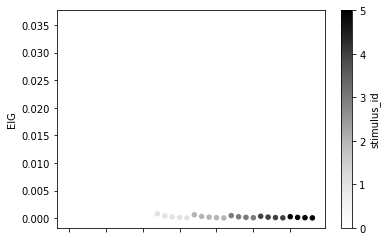

In [ ]:
res.behavior['index_column'] = res.behavior.index
res.behavior.plot.scatter(x = "index_column", y = "EIG", c = "stimulus_id")